In [6]:
import pandas as pd
#from hmmlearn import hmm
import numpy as np
import seaborn as sns
from scipy.stats import norm
import itertools
import matplotlib.pyplot as plt
#from hmmlearn.hmm import GMMHMM
from  sklearn.metrics import mean_squared_error as mse
from astropy.io import fits
import matplotlib.pyplot as plt
import os, sys

def plot_state_matrix(cm, states,title='Transition Probabilities',cmap=plt.cm.Blues):
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(states))
    plt.xticks(tick_marks, states)
    plt.yticks(tick_marks, states)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.1f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2. else "black")
    plt.ylabel('Origin state')
    plt.xlabel('Destination state')
    plt.tight_layout()


dirpath = os.getcwd().split("code")[0]+"code/"
sys.path.append(dirpath)
from pre_process import clean_LC
folder = "/work/work_teamEXOPLANET/KOI_LC/"

time_kepler = np.load(folder+"npy/KOI_LC_time.npy") 
our_process = np.load('/work/work_teamEXOPLANET/KOI_LC/cleaned/LC_kepler_processed.npy')
our_process.shape 

(8054, 71427)

In [7]:
df= pd.read_csv(folder+"csv/kepler_dataset.csv")

df_meta=pd.read_csv('../../KOI_Data/kepler_dataset.csv')
kplr_ids=np.asarray(df['Kepler ID'].values)[[index_fp]]

In [8]:
#### importante:
def prepare_lc(fluxs): #dividir por min
    fluxs = np.asarray(fluxs)
    return fluxs/np.nanstd(fluxs)

def extract_nans(fluxs):
    ###extrae los nans y deja tramos de valores continuos
    lc_wind_nan = []
    lengths = []

    sublist = []
    for value in fluxs:
        if np.isnan(value) and len(sublist) != 0:
            if len(sublist) != 1: ##borrar tramos de largo 1??
                lc_wind_nan.append(np.asarray(sublist))
                lengths.append(len(sublist))
            sublist = []
        elif np.isnan(value) and len(sublist) == 0:
            continue
        else: #if value not nan
            sublist.append(value) 
    lc_wind_nan = np.asarray(lc_wind_nan)   
    lengths = np.asarray(lengths)   

    print("Cantidad de tramos: ",len(lengths))
    print("Largo promedio de tramos: ", np.mean(lengths))
    print("Mediana de largo de tramos: ", np.median(lengths))
    print("Min de largo de tramos: ", np.min(lengths))
    print("Max de largo de tramos: ", np.max(lengths))
    return lc_wind_nan

## Version paralela (Numba)
para instalar numba: **pip install numba**

In [9]:
from numba import njit, jit
#from numba.typed import List

In [10]:
## no python: njit -- no soporta lista de lista, lista de arrays, si soporta: lista de sets

########### no lo logre hacer funcionar
#@njit(parallel=True, cache=False, fastmath=True)
def extract_nans(fluxs, plot=True):
    ###extrae los nans y deja tramos de valores continuos
    lc_wind_nan = []
    lengths = []

    sublist = [] #para que sepa que el tipo es float
    for value in fluxs:
        if np.isnan(value) and len(sublist) != 0:
            if len(sublist) != 1: ##borrar tramos de largo 1??
                lc_wind_nan.append(np.asarray(sublist))
                lengths.append(len(sublist))
            sublist = [] #para que sepa que el tipo es float
        elif np.isnan(value) and len(sublist) == 0:
            continue
        else: #if value not nan
            sublist.append(value) 

    if plot:
        lengths = np.asarray(lengths)   
        print("Cantidad de tramos: ",len(lengths))
        print("Largo promedio de tramos: ", np.mean(lengths))
        print("Mediana de largo de tramos: ", np.median(lengths))
        print("Min de largo de tramos: ", np.min(lengths))
        print("Max de largo de tramos: ", np.max(lengths))
    return lc_wind_nan

@njit(parallel=True, cache=False, fastmath=True)
def det_state(a, b, n_sta):
    topes=np.linspace(a, b, n_sta+1)
    estados= []
    ind=1
    for top in topes[:-1]:
        estados.append((top,topes[ind]))
        ind+=1
    return estados

@njit(parallel=False, cache=True, fastmath=True)
def det_state_2ways(a, b, n_sta_up, n_sta_low):
    estados_up = det_state(a, 0, n_sta_up)
    estados_low = det_state(0, b, n_sta_low)
    return estados_up + estados_low

@njit(parallel=False, cache=True, fastmath=True)
def det_celda(num, estados): 
    for celda, (est_low, est_up) in enumerate(estados):
        if num<est_low and num>=est_up:
            return celda
    return 0 #if sale por arriba (mayor a 1)

@njit(parallel=False, cache=True, fastmath=True)  #no se pudo paralelizar por el acceso a lista "ind -1"
def add_transitions(fluxs, transition_m, states):
    for ind in range(1,len(fluxs)):
        init_s = det_celda(fluxs[ind-1], states)
        fin_s = det_celda(fluxs[ind], states)
        transition_m[init_s, fin_s] += 1
    return transition_m

@njit(parallel=True, cache=False, fastmath=True)
def manual_HMM(wind_fluxs, n_sta_up, n_sta_low=0):
    if n_sta_low == 0: 
        n_sta_low = n_sta_up 
    n_sta = n_sta_up+n_sta_low
    
    transition_m = np.zeros((n_sta,n_sta))
    
    states = det_state_2ways(1,-1, n_sta_up=n_sta_up, n_sta_low=n_sta_low) 
    for fluxs in wind_fluxs:
        add_transitions(fluxs, transition_m, states)
    
    for i in range(n_sta):
        suma_i = 0
        for j in range(n_sta):
            transition_m[i,j] +=1 #priors
            suma_i += transition_m[i,j]
        transition_m[i] = transition_m[i]/suma_i #normalize
    return transition_m


In [25]:
%%time
fluxs = our_process[0]
fluxs = prepare_lc(fluxs) #divide by std
lc_tramos =  extract_nans(fluxs) #extract nans
lc_tramos #lista de tramos...

Cantidad de tramos:  796
Largo promedio de tramos:  80.82663316582915
Mediana de largo de tramos:  79.0
Min de largo de tramos:  2
Max de largo de tramos:  149
CPU times: user 294 ms, sys: 2.19 ms, total: 296 ms
Wall time: 293 ms


[array([-2.35041248e-01, -6.72634028e-01, -2.25381310e-01, -5.15211932e-01,
        -6.57111238e-01,  0.00000000e+00,  1.75773845e-01,  2.80903272e-02,
         8.69942808e-01, -4.64923149e-01,  2.89419289e-01, -2.37810716e-01,
         2.13801088e-01,  3.79622406e-01,  4.69755880e-01,  7.78149161e-01,
         8.06878919e-02, -1.87026867e-01,  2.41283372e-01, -4.02722662e-01,
        -1.65855007e-01, -2.30423560e-01,  7.10372532e-01,  1.76539463e-01,
        -3.09386448e-01, -3.36135822e-02, -4.33049929e-01,  5.39667824e-01,
         9.75077892e-02, -4.62457503e-01,  5.39955984e-01,  3.39124094e-01,
        -3.02806249e-02, -2.37169969e-01,  7.57760068e-02, -2.81404169e-01,
        -1.14222877e-01, -5.93060814e-01,  5.98226099e-03, -4.58696002e-01,
         7.33811347e-02,  8.14591333e-02,  2.19896808e-01,  1.55265327e-01,
        -4.88639822e-01, -3.04577881e-01,  1.60366779e-01,  2.03478064e-01,
         5.35508732e-01, -6.92985874e-01,  5.66965866e-02,  7.66829916e-02,
        -3.0

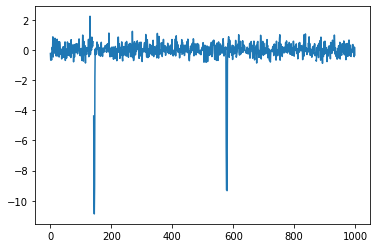

In [27]:
plt.plot(fluxs[:1000])

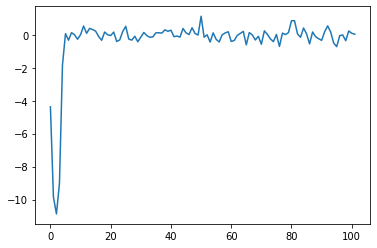

In [30]:
plt.plot(lc_tramos[1])

In [99]:
from scipy.stats import norm

#@njit(parallel=False, cache=True, fastmath=True)
def det_state_norm(n_states):
    w_p = 1./n_states #width of probability
    print("Each bin will have %f perc probability"%(w_p*100))
    
    norm_stand = norm(loc=0, scale=1)
    

    estados_p= []
    estados_num = []
    cum_p = 0
    for n in np.arange(n_states):    
        if n == n_states-1:
            new_p = 1 #no puede ser mayor a 1
            
        estados_p.append((cum_p,new_p))
        estados_num.append((norm_stand.ppf(cum_p),norm_stand.ppf(new_p)))
        cum_p = new_p
    return estados_p, estados_num

In [109]:
#definición de estados basados en percentiles de distribucion normal estandar
#???? dependiendo de los percentiles de curva..
states_prob, states_values = det_state_norm(32)
states_values

Each bin will have 3.125000 perc probability


[(-inf, -1.8627318674216515),
 (-1.8627318674216515, -1.5341205443525463),
 (-1.5341205443525463, -1.318010897303537),
 (-1.318010897303537, -1.1503493803760079),
 (-1.1503493803760079, -1.009990169249582),
 (-1.009990169249582, -0.887146559018876),
 (-0.887146559018876, -0.7764217611479277),
 (-0.7764217611479277, -0.6744897501960817),
 (-0.6744897501960817, -0.579132162255556),
 (-0.579132162255556, -0.4887764111146695),
 (-0.4887764111146695, -0.40225006532172536),
 (-0.40225006532172536, -0.31863936396437514),
 (-0.31863936396437514, -0.23720210932878769),
 (-0.23720210932878769, -0.1573106846101707),
 (-0.1573106846101707, -0.0784124127331122),
 (-0.0784124127331122, 0.0),
 (0.0, 0.0784124127331122),
 (0.0784124127331122, 0.1573106846101707),
 (0.1573106846101707, 0.23720210932878769),
 (0.23720210932878769, 0.31863936396437514),
 (0.31863936396437514, 0.40225006532172536),
 (0.40225006532172536, 0.4887764111146695),
 (0.4887764111146695, 0.579132162255556),
 (0.579132162255556, 0

In [103]:
det_state_2ways(-1, 1, 16, 16)

[(-1.0, -0.9375),
 (-0.9375, -0.875),
 (-0.875, -0.8125),
 (-0.8125, -0.75),
 (-0.75, -0.6875),
 (-0.6875, -0.625),
 (-0.625, -0.5625),
 (-0.5625, -0.5),
 (-0.5, -0.4375),
 (-0.4375, -0.375),
 (-0.375, -0.3125),
 (-0.3125, -0.25),
 (-0.25, -0.1875),
 (-0.1875, -0.125),
 (-0.125, -0.0625),
 (-0.0625, 0.0),
 (0.0, 0.0625),
 (0.0625, 0.125),
 (0.125, 0.1875),
 (0.1875, 0.25),
 (0.25, 0.3125),
 (0.3125, 0.375),
 (0.375, 0.4375),
 (0.4375, 0.5),
 (0.5, 0.5625),
 (0.5625, 0.625),
 (0.625, 0.6875),
 (0.6875, 0.75),
 (0.75, 0.8125),
 (0.8125, 0.875),
 (0.875, 0.9375),
 (0.9375, 1.0)]

### Comportamiento Falsos postiviso

In [5]:
falsos_pos=df.loc[df['NExScI Disposition']=='FALSE POSITIVE']
index_fp=list(falsos_pos.index)
len(index_fp)

our_detrends=our_process[index_fp]
our_detrends.shape

NameError: name 'df' is not defined

recuperando curva 1
Cantidad de tramos:  796
Largo promedio de tramos:  80.82663316582915
Mediana de largo de tramos:  79.0
Min de largo de tramos:  2
Max de largo de tramos:  149


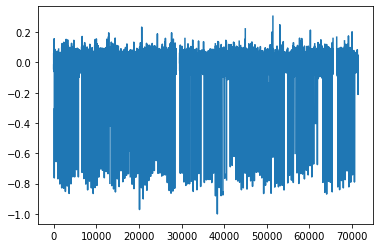

Cantidad de tramos:  796
Largo promedio de tramos:  80.72110552763819
Mediana de largo de tramos:  78.5
Min de largo de tramos:  2
Max de largo de tramos:  149


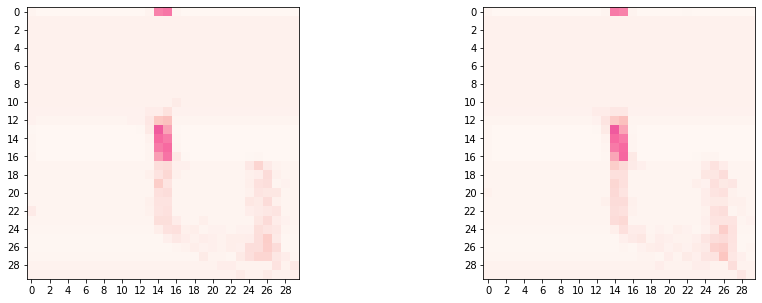

recuperando curva 2
Cantidad de tramos:  807
Largo promedio de tramos:  79.71623296158612
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


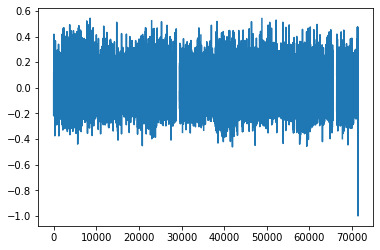

Cantidad de tramos:  807
Largo promedio de tramos:  79.61214374225527
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


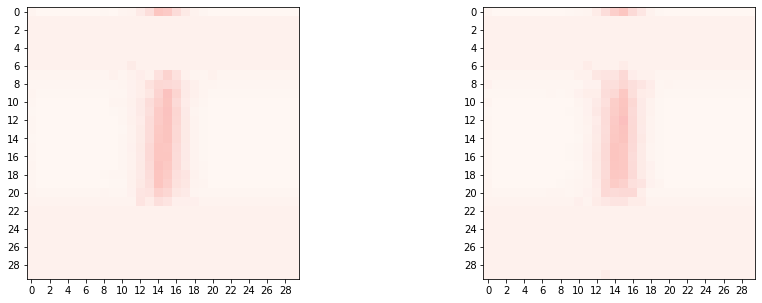

recuperando curva 3
Cantidad de tramos:  822
Largo promedio de tramos:  78.24209245742092
Mediana de largo de tramos:  76.0
Min de largo de tramos:  2
Max de largo de tramos:  146


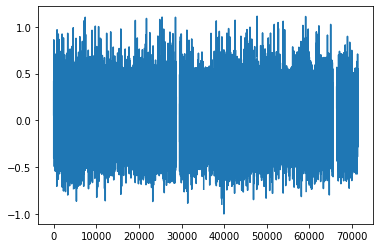

Cantidad de tramos:  822
Largo promedio de tramos:  78.13990267639903
Mediana de largo de tramos:  76.0
Min de largo de tramos:  2
Max de largo de tramos:  146


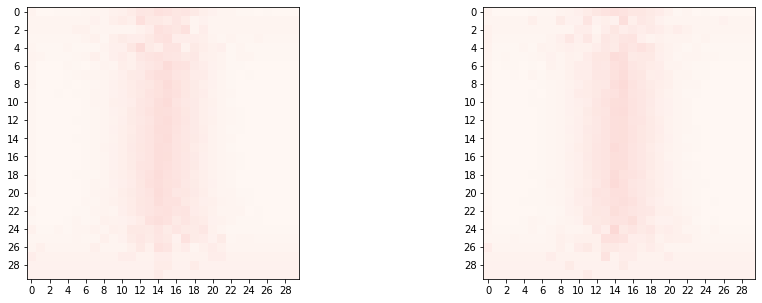

recuperando curva 4
Cantidad de tramos:  863
Largo promedio de tramos:  72.9316338354577
Mediana de largo de tramos:  66.0
Min de largo de tramos:  2
Max de largo de tramos:  146


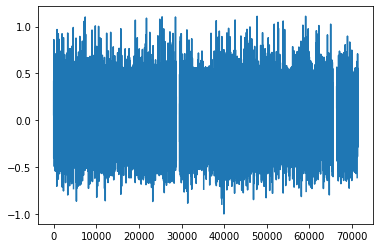

Cantidad de tramos:  863
Largo promedio de tramos:  72.83429895712631
Mediana de largo de tramos:  66.0
Min de largo de tramos:  2
Max de largo de tramos:  146


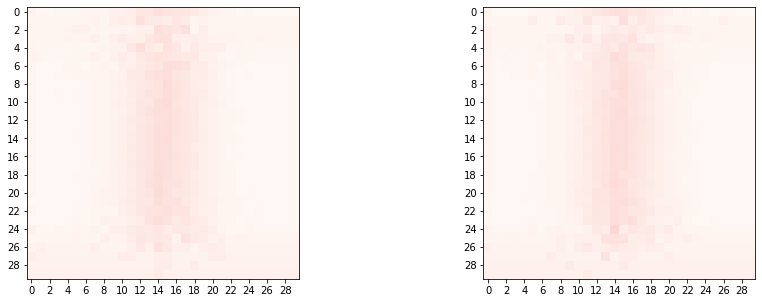

recuperando curva 5
Cantidad de tramos:  824
Largo promedio de tramos:  78.05097087378641
Mediana de largo de tramos:  74.0
Min de largo de tramos:  2
Max de largo de tramos:  149


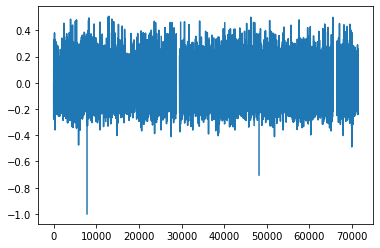

Cantidad de tramos:  824
Largo promedio de tramos:  77.94902912621359
Mediana de largo de tramos:  74.0
Min de largo de tramos:  2
Max de largo de tramos:  149


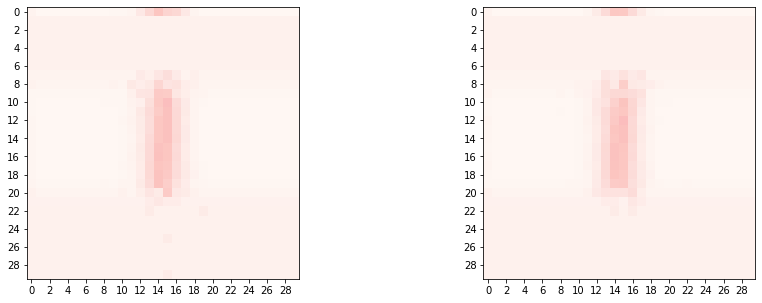

recuperando curva 6
Cantidad de tramos:  680
Largo promedio de tramos:  80.16323529411764
Mediana de largo de tramos:  79.5
Min de largo de tramos:  2
Max de largo de tramos:  146


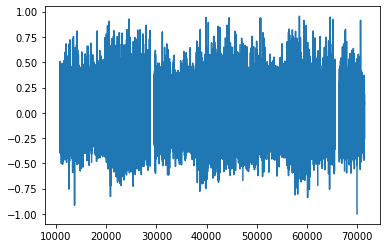

Cantidad de tramos:  681
Largo promedio de tramos:  80.12922173274596
Mediana de largo de tramos:  79.0
Min de largo de tramos:  2
Max de largo de tramos:  146


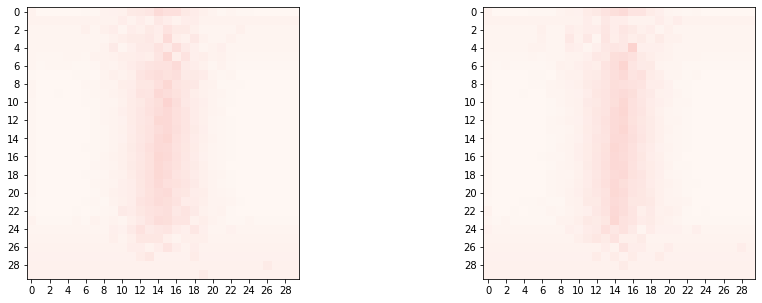

recuperando curva 7
Cantidad de tramos:  843
Largo promedio de tramos:  76.26453143534994
Mediana de largo de tramos:  71.0
Min de largo de tramos:  2
Max de largo de tramos:  149


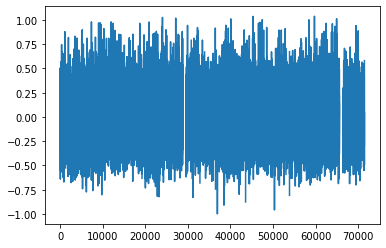

Cantidad de tramos:  843
Largo promedio de tramos:  76.16488730723606
Mediana de largo de tramos:  71.0
Min de largo de tramos:  2
Max de largo de tramos:  149


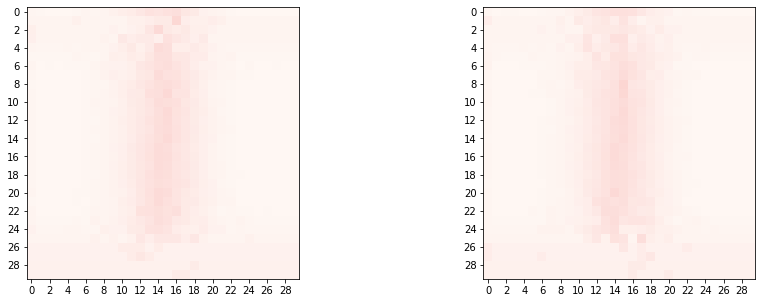

recuperando curva 8
Cantidad de tramos:  818
Largo promedio de tramos:  78.62713936430318
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


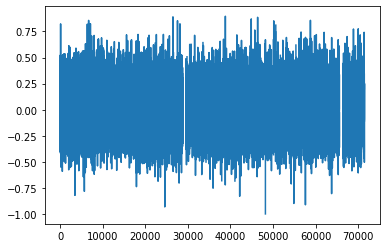

Cantidad de tramos:  818
Largo promedio de tramos:  78.52444987775061
Mediana de largo de tramos:  77.5
Min de largo de tramos:  2
Max de largo de tramos:  149


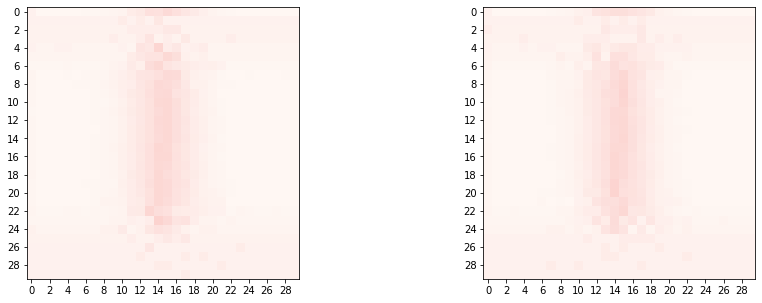

recuperando curva 9
Cantidad de tramos:  822
Largo promedio de tramos:  74.98418491484185
Mediana de largo de tramos:  69.5
Min de largo de tramos:  2
Max de largo de tramos:  149


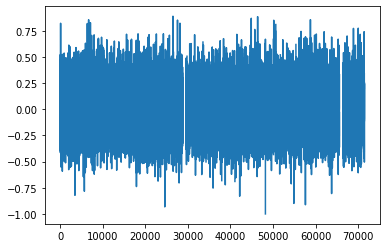

Cantidad de tramos:  822
Largo promedio de tramos:  74.88199513381996
Mediana de largo de tramos:  69.0
Min de largo de tramos:  2
Max de largo de tramos:  149


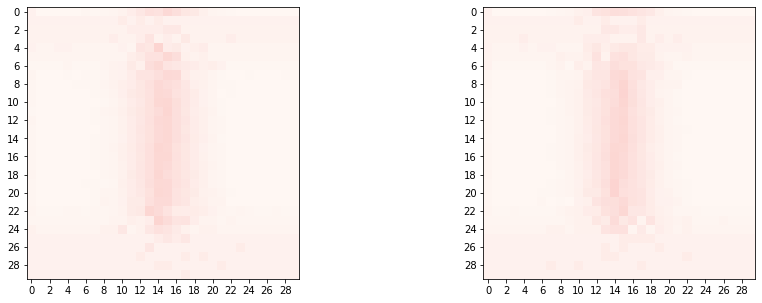

recuperando curva 10
Cantidad de tramos:  160
Largo promedio de tramos:  82.05
Mediana de largo de tramos:  88.0
Min de largo de tramos:  2
Max de largo de tramos:  145


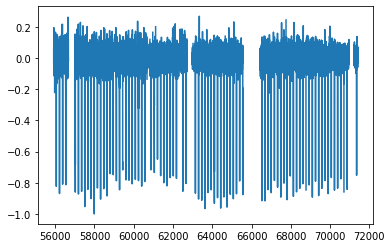

Cantidad de tramos:  161
Largo promedio de tramos:  81.8944099378882
Mediana de largo de tramos:  88.0
Min de largo de tramos:  2
Max de largo de tramos:  145


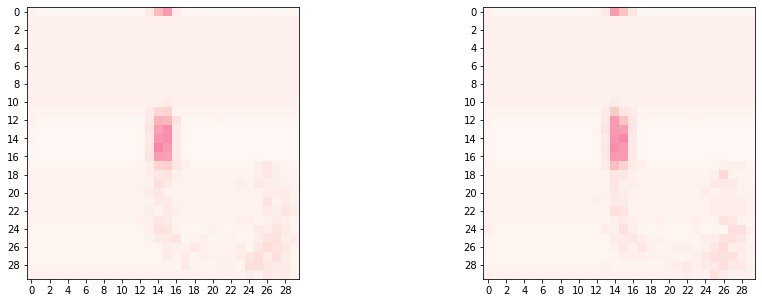

recuperando curva 11
Cantidad de tramos:  815
Largo promedio de tramos:  78.92515337423313
Mediana de largo de tramos:  76.0
Min de largo de tramos:  2
Max de largo de tramos:  149


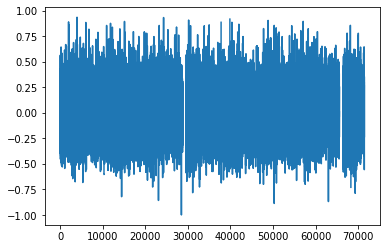

Cantidad de tramos:  815
Largo promedio de tramos:  78.82208588957056
Mediana de largo de tramos:  76.0
Min de largo de tramos:  2
Max de largo de tramos:  149


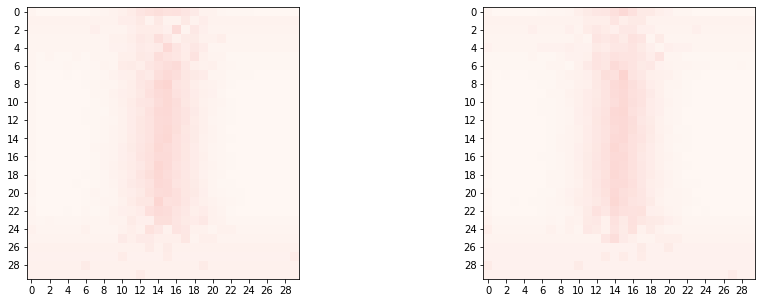

recuperando curva 12
Cantidad de tramos:  825
Largo promedio de tramos:  77.94787878787879
Mediana de largo de tramos:  76.0
Min de largo de tramos:  2
Max de largo de tramos:  149


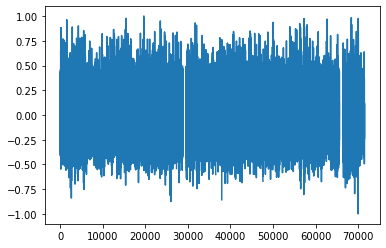

Cantidad de tramos:  825
Largo promedio de tramos:  77.8460606060606
Mediana de largo de tramos:  76.0
Min de largo de tramos:  2
Max de largo de tramos:  149


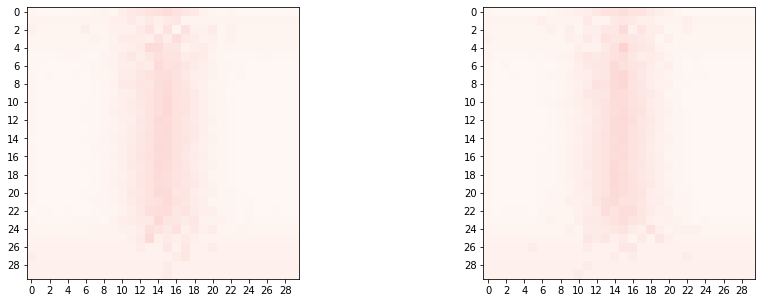

recuperando curva 13
Cantidad de tramos:  831
Largo promedio de tramos:  77.38146811070999
Mediana de largo de tramos:  74.0
Min de largo de tramos:  2
Max de largo de tramos:  149


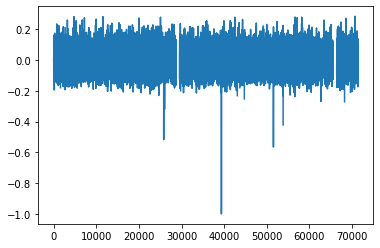

Cantidad de tramos:  831
Largo promedio de tramos:  77.28038507821901
Mediana de largo de tramos:  73.0
Min de largo de tramos:  2
Max de largo de tramos:  149


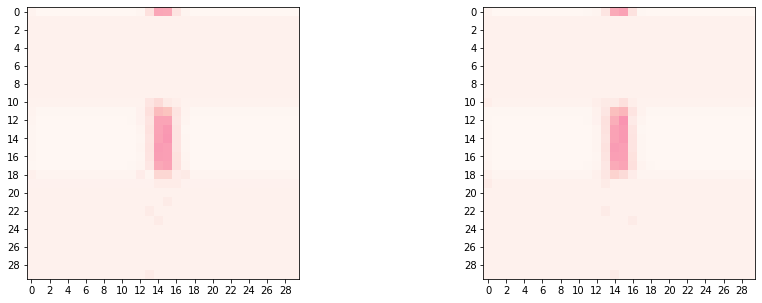

recuperando curva 14
Cantidad de tramos:  801
Largo promedio de tramos:  80.32209737827715
Mediana de largo de tramos:  80.0
Min de largo de tramos:  2
Max de largo de tramos:  149


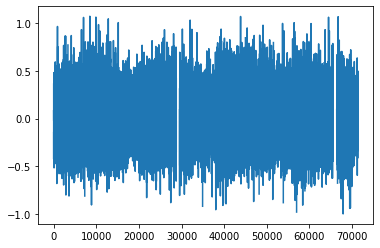

Cantidad de tramos:  801
Largo promedio de tramos:  80.21722846441948
Mediana de largo de tramos:  80.0
Min de largo de tramos:  2
Max de largo de tramos:  149


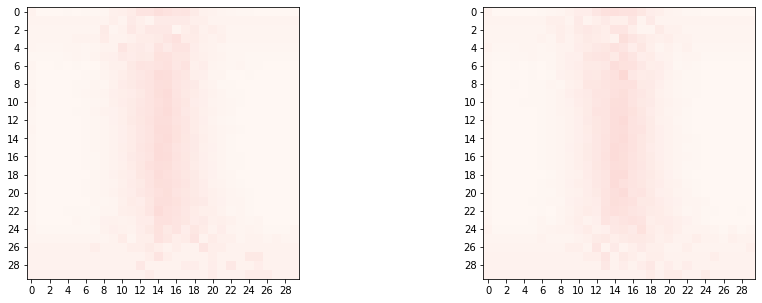

recuperando curva 15
Cantidad de tramos:  857
Largo promedio de tramos:  72.44690781796966
Mediana de largo de tramos:  62.0
Min de largo de tramos:  2
Max de largo de tramos:  149


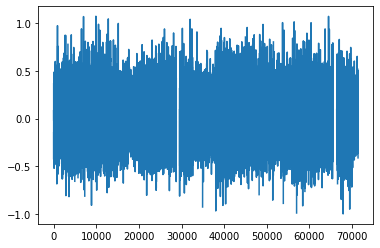

Cantidad de tramos:  857
Largo promedio de tramos:  72.34889148191365
Mediana de largo de tramos:  62.0
Min de largo de tramos:  2
Max de largo de tramos:  149


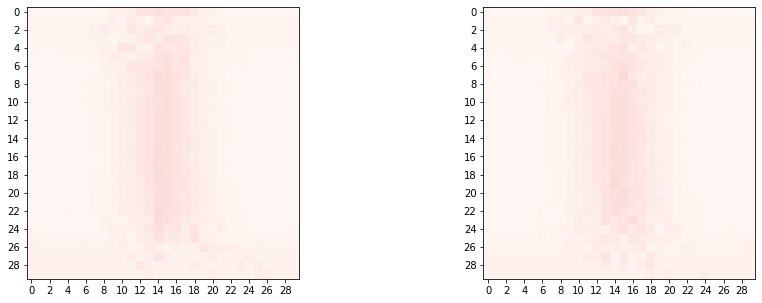

recuperando curva 16
Cantidad de tramos:  812
Largo promedio de tramos:  79.18349753694581
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


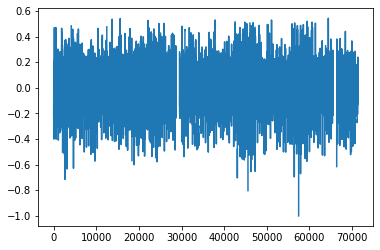

Cantidad de tramos:  812
Largo promedio de tramos:  79.08004926108374
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


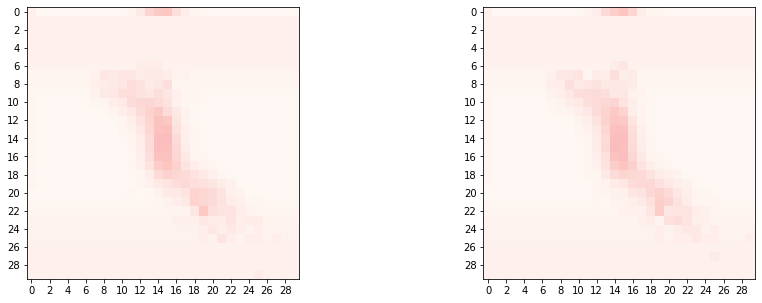

recuperando curva 17
Cantidad de tramos:  912
Largo promedio de tramos:  67.91228070175438
Mediana de largo de tramos:  58.0
Min de largo de tramos:  2
Max de largo de tramos:  146


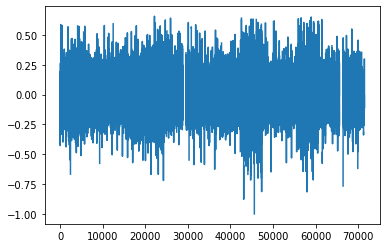

Cantidad de tramos:  912
Largo promedio de tramos:  67.90131578947368
Mediana de largo de tramos:  58.0
Min de largo de tramos:  2
Max de largo de tramos:  146


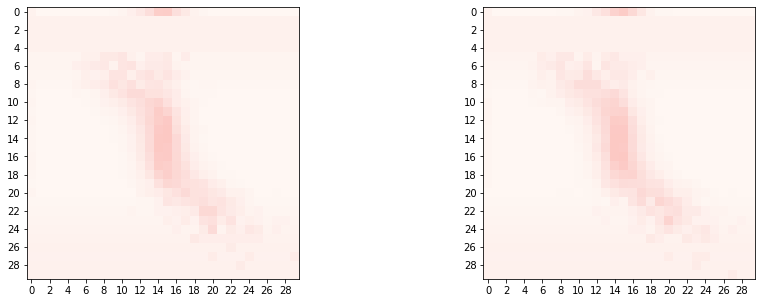

recuperando curva 18
Cantidad de tramos:  832
Largo promedio de tramos:  77.28966346153847
Mediana de largo de tramos:  75.0
Min de largo de tramos:  2
Max de largo de tramos:  149


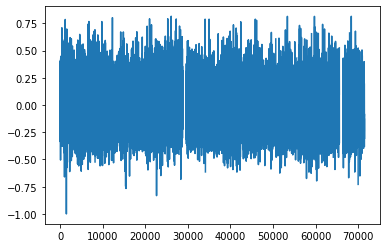

Cantidad de tramos:  832
Largo promedio de tramos:  77.18870192307692
Mediana de largo de tramos:  74.5
Min de largo de tramos:  2
Max de largo de tramos:  149


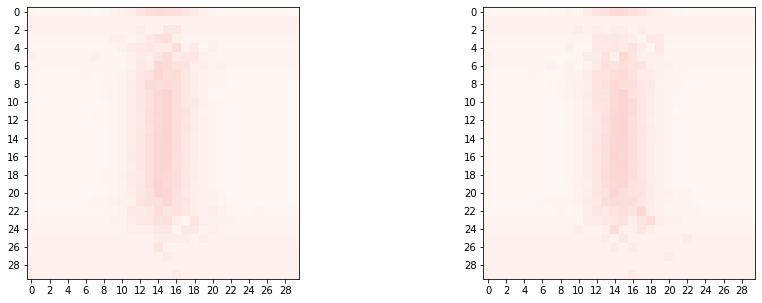

recuperando curva 19
Cantidad de tramos:  816
Largo promedio de tramos:  78.82107843137256
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


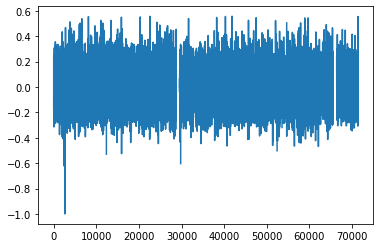

Cantidad de tramos:  816
Largo promedio de tramos:  78.71813725490196
Mediana de largo de tramos:  77.5
Min de largo de tramos:  2
Max de largo de tramos:  149


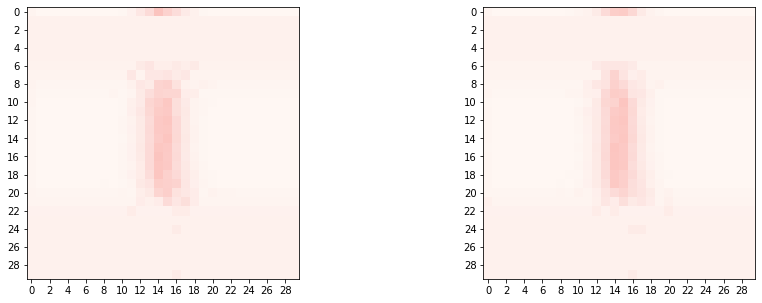

recuperando curva 20
Cantidad de tramos:  1017
Largo promedio de tramos:  57.44051130776794
Mediana de largo de tramos:  47.0
Min de largo de tramos:  2
Max de largo de tramos:  149


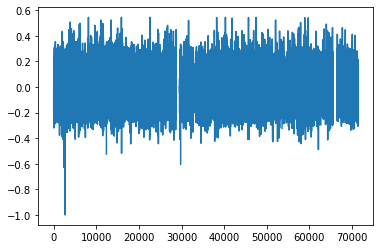

Cantidad de tramos:  1017
Largo promedio de tramos:  57.3913470993117
Mediana de largo de tramos:  47.0
Min de largo de tramos:  2
Max de largo de tramos:  149


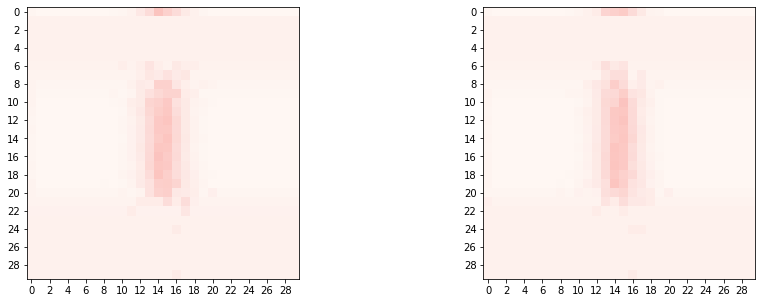

CPU times: user 21.4 s, sys: 549 ms, total: 21.9 s
Wall time: 20.8 s


In [37]:
%%time

i=0
for lc_our_detrend in our_detrends[:20]:   
    print ("recuperando curva",i+1)
    fluxs = prepare_lc(lc_our_detrend) #divide by min
    lc_tramos =  extract_nans(fluxs) #extract nans
    plt.plot(fluxs)
    plt.show()
    
    transition_m = manual_HMM(lc_tramos, n_sta_up=15, n_sta_low=15) #si se dejan 5 arriba y 10 abajo cambia harto...

    i+=1
    
    labels_x = [str(value) for value in np.arange(0,transition_m.shape[0],2)]
    
    f, axx = plt.subplots(1, 2,figsize= (15,5))
    axx[0].imshow(transition_m, cmap='RdPu', vmin=0, vmax=1) #el plot se ve raro por esto..
    axx[0].set_xticks(np.arange(0,transition_m.shape[0],2))
    axx[0].set_yticks(np.arange(0,transition_m.shape[0],2))
    axx[0].set_xticklabels(labels_x)
    axx[0].set_yticklabels(labels_x)
    
    #curva en reversa...
    fluxs = prepare_lc(lc_our_detrend[::-1]) #divide by min\n",
    lc_tramos =  extract_nans(fluxs) #extract nans
    transition_m = manual_HMM(lc_tramos, n_sta_up=15, n_sta_low=15) #si se dejan 5 arriba y 10 abajo cambia harto...
    
    axx[1].imshow(transition_m, cmap='RdPu', vmin=0, vmax=1) #el plot se ve raro por esto..
    axx[1].set_xticks(np.arange(0,transition_m.shape[0],2))
    axx[1].set_yticks(np.arange(0,transition_m.shape[0],2))
    axx[1].set_xticklabels(labels_x)
    axx[1].set_yticklabels(labels_x)
    
    plt.show()

### Comportamiento Confirmados

In [38]:
confirmados=df.loc[df['NExScI Disposition']=='CONFIRMED']
index_con=list(confirmados.index)
our_detrends=our_process[index_con]
len(index_con)

2281

recuperando curva 1
Cantidad de tramos:  796
Largo promedio de tramos:  80.82663316582915
Mediana de largo de tramos:  79.0
Min de largo de tramos:  2
Max de largo de tramos:  149
Cantidad de tramos:  796
Largo promedio de tramos:  80.72110552763819
Mediana de largo de tramos:  78.5
Min de largo de tramos:  2
Max de largo de tramos:  149


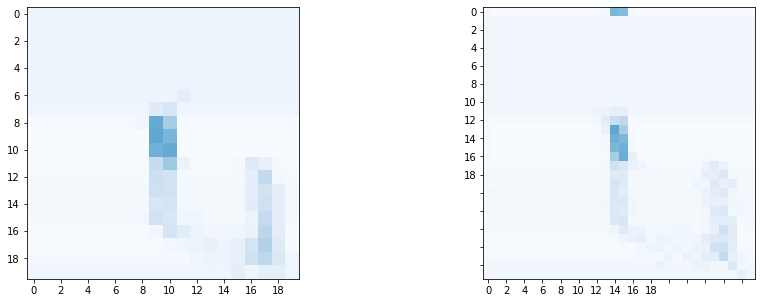

recuperando curva 2
Cantidad de tramos:  807
Largo promedio de tramos:  79.71623296158612
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149
Cantidad de tramos:  807
Largo promedio de tramos:  79.61214374225527
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


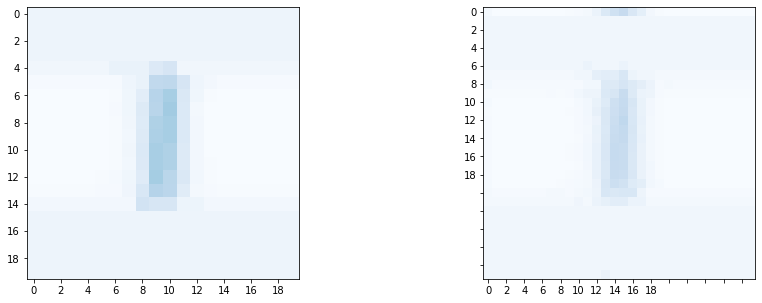

recuperando curva 3
Cantidad de tramos:  822
Largo promedio de tramos:  78.24209245742092
Mediana de largo de tramos:  76.0
Min de largo de tramos:  2
Max de largo de tramos:  146
Cantidad de tramos:  822
Largo promedio de tramos:  78.13990267639903
Mediana de largo de tramos:  76.0
Min de largo de tramos:  2
Max de largo de tramos:  146


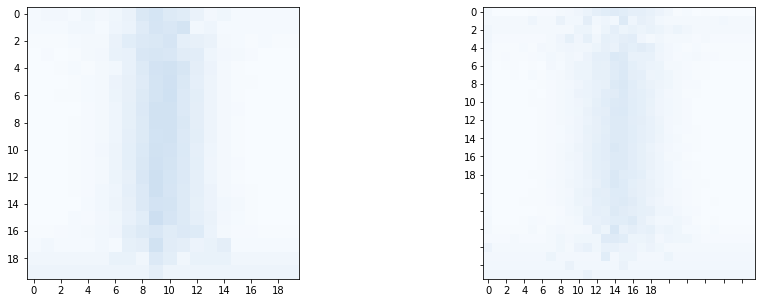

recuperando curva 4
Cantidad de tramos:  863
Largo promedio de tramos:  72.9316338354577
Mediana de largo de tramos:  66.0
Min de largo de tramos:  2
Max de largo de tramos:  146
Cantidad de tramos:  863
Largo promedio de tramos:  72.83429895712631
Mediana de largo de tramos:  66.0
Min de largo de tramos:  2
Max de largo de tramos:  146


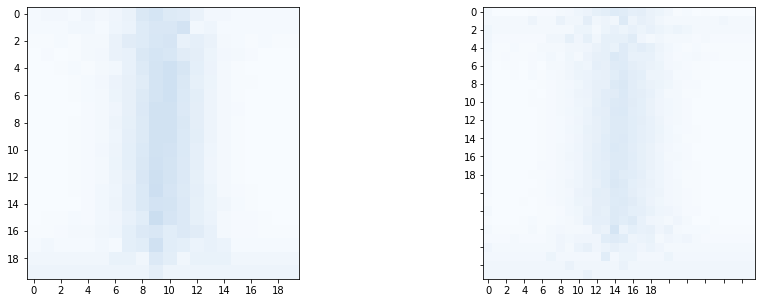

recuperando curva 5
Cantidad de tramos:  824
Largo promedio de tramos:  78.05097087378641
Mediana de largo de tramos:  74.0
Min de largo de tramos:  2
Max de largo de tramos:  149
Cantidad de tramos:  824
Largo promedio de tramos:  77.94902912621359
Mediana de largo de tramos:  74.0
Min de largo de tramos:  2
Max de largo de tramos:  149


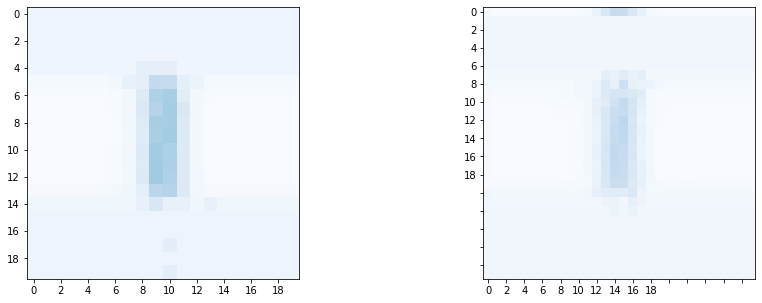

recuperando curva 6
Cantidad de tramos:  680
Largo promedio de tramos:  80.16323529411764
Mediana de largo de tramos:  79.5
Min de largo de tramos:  2
Max de largo de tramos:  146
Cantidad de tramos:  681
Largo promedio de tramos:  80.12922173274596
Mediana de largo de tramos:  79.0
Min de largo de tramos:  2
Max de largo de tramos:  146


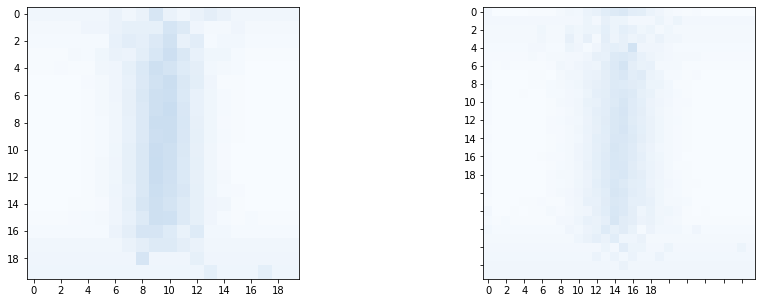

recuperando curva 7
Cantidad de tramos:  843
Largo promedio de tramos:  76.26453143534994
Mediana de largo de tramos:  71.0
Min de largo de tramos:  2
Max de largo de tramos:  149
Cantidad de tramos:  843
Largo promedio de tramos:  76.16488730723606
Mediana de largo de tramos:  71.0
Min de largo de tramos:  2
Max de largo de tramos:  149


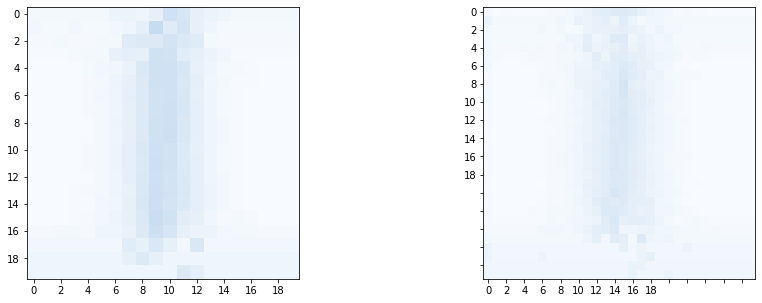

recuperando curva 8
Cantidad de tramos:  818
Largo promedio de tramos:  78.62713936430318
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149
Cantidad de tramos:  818
Largo promedio de tramos:  78.52444987775061
Mediana de largo de tramos:  77.5
Min de largo de tramos:  2
Max de largo de tramos:  149


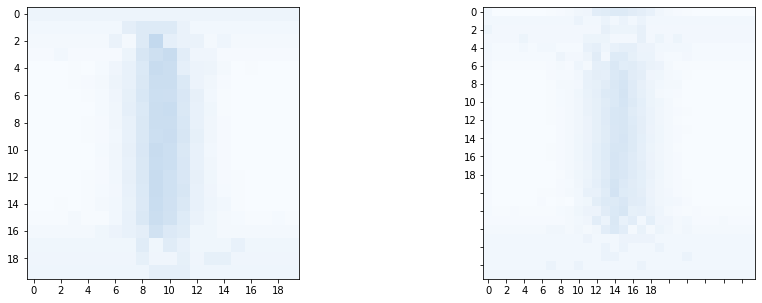

recuperando curva 9
Cantidad de tramos:  822
Largo promedio de tramos:  74.98418491484185
Mediana de largo de tramos:  69.5
Min de largo de tramos:  2
Max de largo de tramos:  149
Cantidad de tramos:  822
Largo promedio de tramos:  74.88199513381996
Mediana de largo de tramos:  69.0
Min de largo de tramos:  2
Max de largo de tramos:  149


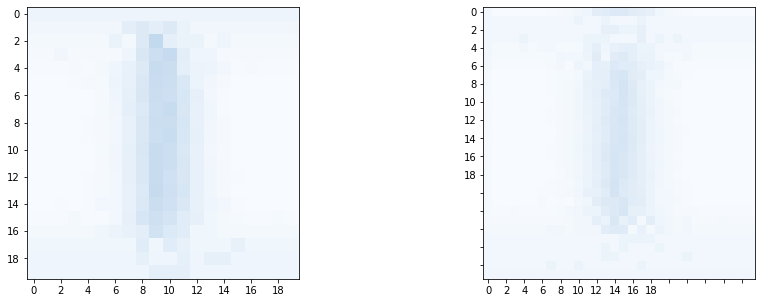

recuperando curva 10
Cantidad de tramos:  160
Largo promedio de tramos:  82.05
Mediana de largo de tramos:  88.0
Min de largo de tramos:  2
Max de largo de tramos:  145
Cantidad de tramos:  161
Largo promedio de tramos:  81.8944099378882
Mediana de largo de tramos:  88.0
Min de largo de tramos:  2
Max de largo de tramos:  145


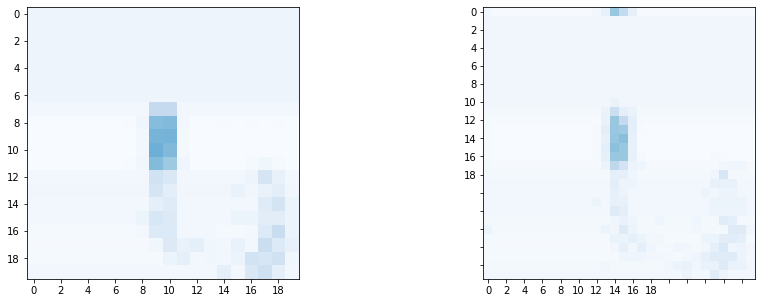

recuperando curva 11
Cantidad de tramos:  815
Largo promedio de tramos:  78.92515337423313
Mediana de largo de tramos:  76.0
Min de largo de tramos:  2
Max de largo de tramos:  149
Cantidad de tramos:  815
Largo promedio de tramos:  78.82208588957056
Mediana de largo de tramos:  76.0
Min de largo de tramos:  2
Max de largo de tramos:  149


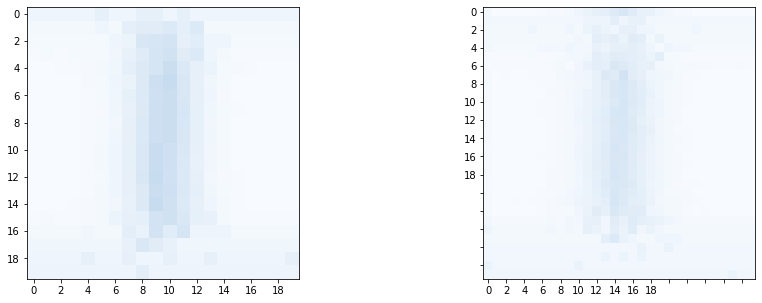

recuperando curva 12
Cantidad de tramos:  825
Largo promedio de tramos:  77.94787878787879
Mediana de largo de tramos:  76.0
Min de largo de tramos:  2
Max de largo de tramos:  149
Cantidad de tramos:  825
Largo promedio de tramos:  77.8460606060606
Mediana de largo de tramos:  76.0
Min de largo de tramos:  2
Max de largo de tramos:  149


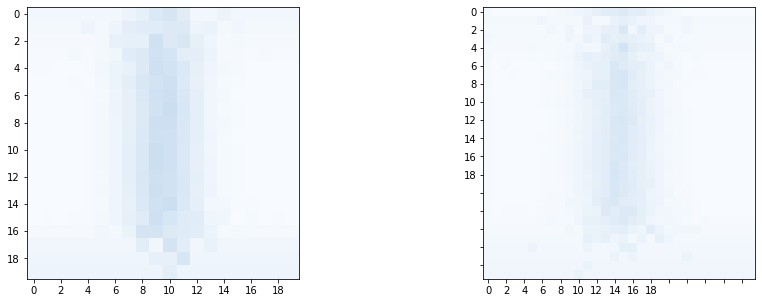

recuperando curva 13
Cantidad de tramos:  831
Largo promedio de tramos:  77.38146811070999
Mediana de largo de tramos:  74.0
Min de largo de tramos:  2
Max de largo de tramos:  149
Cantidad de tramos:  831
Largo promedio de tramos:  77.28038507821901
Mediana de largo de tramos:  73.0
Min de largo de tramos:  2
Max de largo de tramos:  149


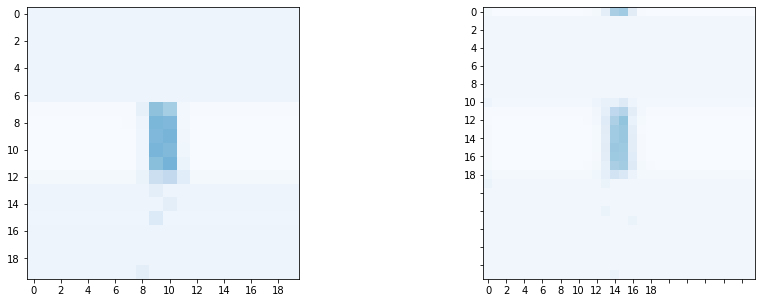

recuperando curva 14
Cantidad de tramos:  801
Largo promedio de tramos:  80.32209737827715
Mediana de largo de tramos:  80.0
Min de largo de tramos:  2
Max de largo de tramos:  149
Cantidad de tramos:  801
Largo promedio de tramos:  80.21722846441948
Mediana de largo de tramos:  80.0
Min de largo de tramos:  2
Max de largo de tramos:  149


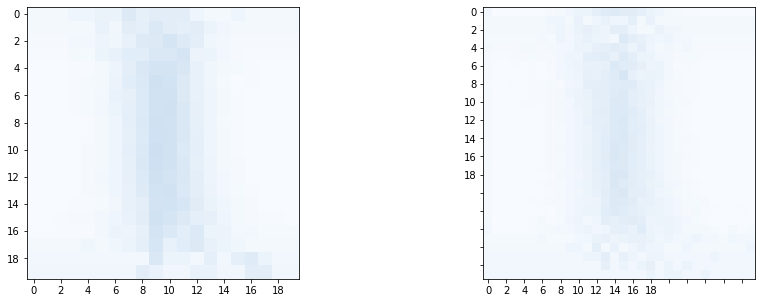

recuperando curva 15
Cantidad de tramos:  857
Largo promedio de tramos:  72.44690781796966
Mediana de largo de tramos:  62.0
Min de largo de tramos:  2
Max de largo de tramos:  149
Cantidad de tramos:  857
Largo promedio de tramos:  72.34889148191365
Mediana de largo de tramos:  62.0
Min de largo de tramos:  2
Max de largo de tramos:  149


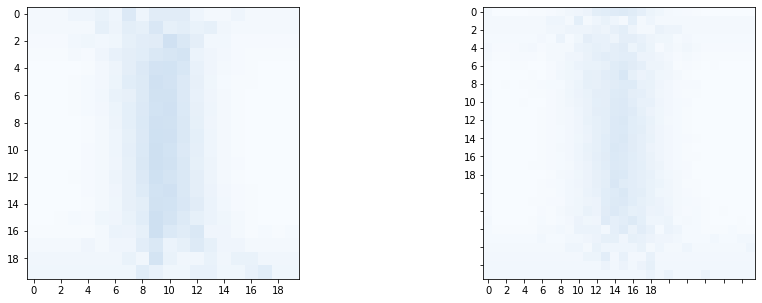

recuperando curva 16
Cantidad de tramos:  812
Largo promedio de tramos:  79.18349753694581
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149
Cantidad de tramos:  812
Largo promedio de tramos:  79.08004926108374
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


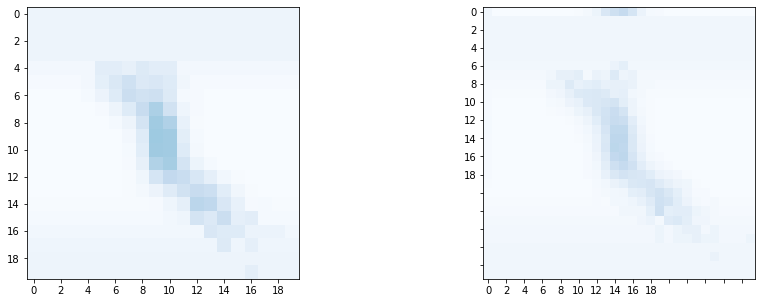

recuperando curva 17
Cantidad de tramos:  912
Largo promedio de tramos:  67.91228070175438
Mediana de largo de tramos:  58.0
Min de largo de tramos:  2
Max de largo de tramos:  146
Cantidad de tramos:  912
Largo promedio de tramos:  67.90131578947368
Mediana de largo de tramos:  58.0
Min de largo de tramos:  2
Max de largo de tramos:  146


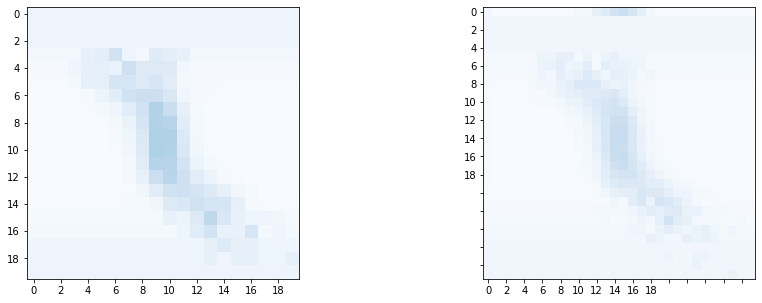

recuperando curva 18
Cantidad de tramos:  832
Largo promedio de tramos:  77.28966346153847
Mediana de largo de tramos:  75.0
Min de largo de tramos:  2
Max de largo de tramos:  149
Cantidad de tramos:  832
Largo promedio de tramos:  77.18870192307692
Mediana de largo de tramos:  74.5
Min de largo de tramos:  2
Max de largo de tramos:  149


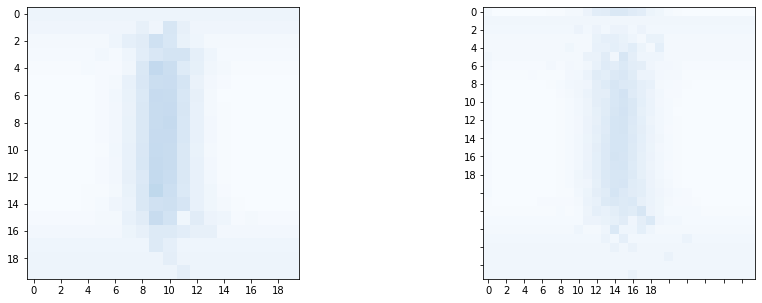

recuperando curva 19
Cantidad de tramos:  816
Largo promedio de tramos:  78.82107843137256
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149
Cantidad de tramos:  816
Largo promedio de tramos:  78.71813725490196
Mediana de largo de tramos:  77.5
Min de largo de tramos:  2
Max de largo de tramos:  149


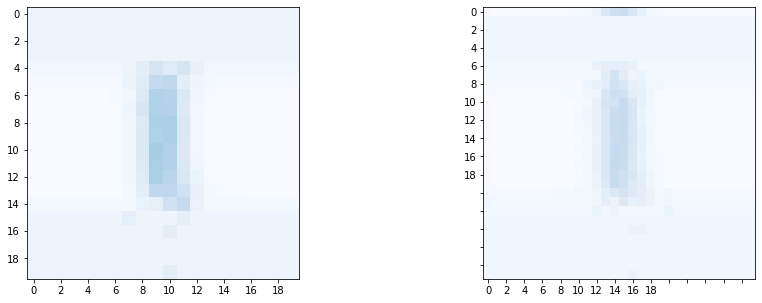

recuperando curva 20
Cantidad de tramos:  1017
Largo promedio de tramos:  57.44051130776794
Mediana de largo de tramos:  47.0
Min de largo de tramos:  2
Max de largo de tramos:  149
Cantidad de tramos:  1017
Largo promedio de tramos:  57.3913470993117
Mediana de largo de tramos:  47.0
Min de largo de tramos:  2
Max de largo de tramos:  149


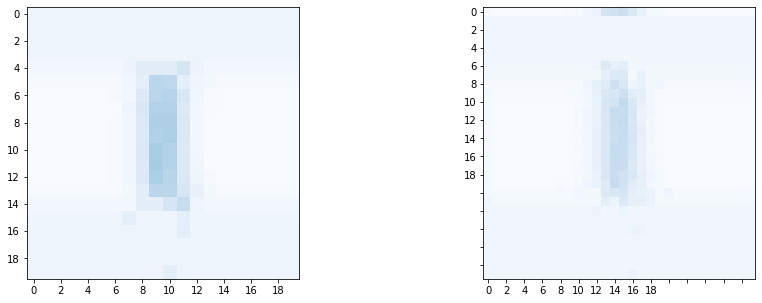

CPU times: user 15.1 s, sys: 463 ms, total: 15.5 s
Wall time: 14.6 s


In [39]:
%%time

i=0
for lc_our_detrend in our_detrends[:20]:   
    print ("recuperando curva",i+1)
    fluxs = prepare_lc(lc_our_detrend) #divide by min
    lc_tramos =  extract_nans(fluxs) #extract nans
    
    transition_m = manual_HMM(lc_tramos, n_sta_up=10, n_sta_low=10) #si se dejan 5 arriba y 10 abajo cambia harto...

    i+=1
    labels_x = [str(value) for value in np.arange(0,transition_m.shape[0],2)]
    
    f, axx = plt.subplots(1, 2,figsize= (15,5))
    axx[0].imshow(transition_m, cmap='Blues', vmin=0, vmax=1) #el plot se ve raro por esto..
    axx[0].set_xticks(np.arange(0,transition_m.shape[0],2))
    axx[0].set_yticks(np.arange(0,transition_m.shape[0],2))
    axx[0].set_xticklabels(labels_x)
    axx[0].set_yticklabels(labels_x)
    
    #curva en reversa...
    fluxs = prepare_lc(lc_our_detrend[::-1]) #divide by min\n",
    lc_tramos =  extract_nans(fluxs) #extract nans
    transition_m = manual_HMM(lc_tramos, n_sta_up=15, n_sta_low=15) #si se dejan 5 arriba y 10 abajo cambia harto...
    
    axx[1].imshow(transition_m, cmap='Blues', vmin=0, vmax=1) #el plot se ve raro por esto..
    axx[1].set_xticks(np.arange(0,transition_m.shape[0],2))
    axx[1].set_yticks(np.arange(0,transition_m.shape[0],2))
    axx[1].set_xticklabels(labels_x)
    axx[1].set_yticklabels(labels_x)
    plt.show()

### Normal (izq - der) NO BORRAR

In [9]:
ups=[16,32,64]
downs=[16,32,64]

In [12]:
for arriba in ups:
    for abajo in downs:
        matrices=[]
        print ("ARRIBA Y ABAJO", arriba,abajo)
        i=0
        for lc_our_detrend in our_process: 
            fluxs = prepare_lc(lc_our_detrend) #divide by min\n",
            lc_tramos =  extract_nans(fluxs, plot=False) #extract nans\n",
            transition_m = manual_HMM(lc_tramos, n_sta_up=arriba, n_sta_low=abajo) #si se dejan 5 arriba y 10 abajo cambia harto...\n",
            i+=1
            matrices.append(transition_m)

        matrices = np.asarray(matrices)

        folder2 = "/work/work_teamEXOPLANET/MTF_margarita/no_invertidos/"
        np.save(folder2+'MTF_u'+str(arriba)+"_d"+str(abajo)+".npy", matrices)
        print("Creada la configuracion")

ARRIBA Y ABAJO 16 16
Creada la configuracion
ARRIBA Y ABAJO 16 32
Creada la configuracion
ARRIBA Y ABAJO 16 64
Creada la configuracion
ARRIBA Y ABAJO 32 16
Creada la configuracion
ARRIBA Y ABAJO 32 32
Creada la configuracion
ARRIBA Y ABAJO 32 64
Creada la configuracion
ARRIBA Y ABAJO 64 16
Creada la configuracion
ARRIBA Y ABAJO 64 32
Creada la configuracion
ARRIBA Y ABAJO 64 64
Creada la configuracion


In [11]:
for arriba in ups:
    for abajo in downs:
        matrices=[]
        print ("ARRIBA Y ABAJO", arriba,abajo)
        i=0
        for lc_our_detrend in our_process: 
            fluxs = prepare_lc(lc_our_detrend[::-1]) #divide by min\n",
            lc_tramos =  extract_nans(fluxs, plot=False) #extract nans\n",
            transition_m = manual_HMM(lc_tramos, n_sta_up=arriba, n_sta_low=abajo) #si se dejan 5 arriba y 10 abajo cambia harto...\n",
            i+=1
            matrices.append(transition_m)

        matrices = np.asarray(matrices)

        folder2 = "/work/work_teamEXOPLANET/MTF_margarita/invertidos/"
        np.save(folder2+'MTF_u'+str(arriba)+"_d"+str(abajo)+".npy", matrices)
        print("Creada la configuracion")

ARRIBA Y ABAJO 16 16
Creada la configuracion
ARRIBA Y ABAJO 16 32
Creada la configuracion
ARRIBA Y ABAJO 16 64
Creada la configuracion
ARRIBA Y ABAJO 32 16
Creada la configuracion
ARRIBA Y ABAJO 32 32
Creada la configuracion
ARRIBA Y ABAJO 32 64
Creada la configuracion
ARRIBA Y ABAJO 64 16
Creada la configuracion
ARRIBA Y ABAJO 64 32
Creada la configuracion
ARRIBA Y ABAJO 64 64
Creada la configuracion
